In [1]:
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#import sys
import os
import numpy as np
import random as rn
import pandas as pd
import re
import torch
from transformers import BertModel
from torch import nn
import tensorflow
from tensorflow.keras.datasets import imdb 
from transformers import BertTokenizer
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
%matplotlib inline
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/McGill/COMP 551/Mini3/"
# df = pd.read_csv(path + "IMDB Dataset.csv")
# labels = df.loc[:,"sentiment"].to_numpy()
# labels = np.where(labels == "positive", 1, 0)
# df["sentiment"] = labels
# Please update the path to the csv file according to your own location.


train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

x_train = train['Sentences']
y_train = train['Sentiment']

x_test = test['Sentences']
y_test = test['Sentiment']

train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], x_train))

test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], x_test))

len(train_tokens), len(test_tokens)

train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
word_index=tokenizer.get_vocab()

reverse_word_index = dict((value,key) for key,value in word_index.items())
print(word_index)
print(x_test)


{'[PAD]': 0, '[unused0]': 1, '[unused1]': 2, '[unused2]': 3, '[unused3]': 4, '[unused4]': 5, '[unused5]': 6, '[unused6]': 7, '[unused7]': 8, '[unused8]': 9, '[unused9]': 10, '[unused10]': 11, '[unused11]': 12, '[unused12]': 13, '[unused13]': 14, '[unused14]': 15, '[unused15]': 16, '[unused16]': 17, '[unused17]': 18, '[unused18]': 19, '[unused19]': 20, '[unused20]': 21, '[unused21]': 22, '[unused22]': 23, '[unused23]': 24, '[unused24]': 25, '[unused25]': 26, '[unused26]': 27, '[unused27]': 28, '[unused28]': 29, '[unused29]': 30, '[unused30]': 31, '[unused31]': 32, '[unused32]': 33, '[unused33]': 34, '[unused34]': 35, '[unused35]': 36, '[unused36]': 37, '[unused37]': 38, '[unused38]': 39, '[unused39]': 40, '[unused40]': 41, '[unused41]': 42, '[unused42]': 43, '[unused43]': 44, '[unused44]': 45, '[unused45]': 46, '[unused46]': 47, '[unused47]': 48, '[unused48]': 49, '[unused49]': 50, '[unused50]': 51, '[unused51]': 52, '[unused52]': 53, '[unused53]': 54, '[unused54]': 55, '[unused55]': 56

In [6]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=False, output_attentions=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
        self.attention = None

    def forward(self, tokens, masks=None):
        _, pooled_output, attentions = self.bert(tokens, attention_mask=masks, output_hidden_states=False, output_attentions=True)#layer x batch x head x seq_len x seq_len
        self.attention = attentions
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled, attentions = bert_clf.bert(x, output_hidden_states=False, output_attentions=True)
y = bert_clf(x)
y.cpu().detach().numpy()

y, x, pooled = None, None, None

torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
import gc
gc.collect()
# str(torch.cuda.memory_allocated(device)/1000000 ) + 'M' 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


77

In [8]:
# Setting hyper-parameters

BATCH_SIZE = 2
EPOCHS = 2

In [9]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
try:
  train_y_tensor = torch.tensor(y_train.to_numpy().reshape(-1, 1)).float()
except:
  train_y_tensor = torch.tensor(y_train.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)

try:
  test_y_tensor = torch.tensor((y_test.to_numpy()).reshape(-1, 1)).float()
except:
  test_y_tensor = torch.tensor((y_test).reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(bert_clf.parameters(), lr=3e-6)
torch.cuda.empty_cache() 

In [10]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num+1, len(x_train) / BATCH_SIZE, train_loss / (step_num + 1)))
        

Epoch:  2
1000/1000.0 loss: 0.3534261749107391 


In [11]:
bert_clf.eval()
bert_predicted = []
all_logits = []

correct_prediction_ids = []
incorrect_predictions_ids = []

i = 0
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        if(bert_predicted[i] == y_test[i]):
          correct_prediction_ids.append(i)
        else:
          incorrect_predictions_ids.append(i)
        i=i+1

        all_logits += list(numpy_logits[:, 0])

In [12]:
print(classification_report(y_test, bert_predicted))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       250
           1       0.90      0.92      0.91       250

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



In [13]:
print(correct_prediction_ids)
print(incorrect_predictions_ids)
print(float(len(correct_prediction_ids))/float(len(incorrect_predictions_ids + correct_prediction_ids)))

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 128, 129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244

In [14]:
#a 1999 a1 1249 12 1499
import seaborn as sns

attentions = bert_clf.attention

print((np.count_nonzero(test_tokens_ids[0])))
print((np.count_nonzero(test_tokens_ids[1])))
word_ls = list(map(lambda x: reverse_word_index.get(int(x)), test_tokens_ids[249]))

a2 = pd.DataFrame(attentions[11][0][0].cpu().detach().numpy(), word_ls, word_ls)#layer x batch x head x seq_len x seq_len
a2 = (a2 - a2.mean())/a2.std()
a2 = a2.iloc[:np.count_nonzero(test_tokens_ids[249]),:np.count_nonzero(test_tokens_ids[249])]


146
137


In [15]:
print((np.count_nonzero(test_tokens_ids[249])))

162


In [16]:
train_tokens_ids[correct_prediction_ids[0]:correct_prediction_ids[0]+1]
y, pooled, attentions = bert_clf.bert(torch.tensor(test_tokens_ids[correct_prediction_ids[0]:correct_prediction_ids[0]+1]).to(device), output_hidden_states=False, output_attentions=True)

In [17]:
print(tokenizer.decode(test_tokens_ids[correct_prediction_ids[0]]))
print((np.count_nonzero(test_tokens_ids[correct_prediction_ids[0]])))
word_ls1 = list(map(lambda x: reverse_word_index.get(int(x)), test_tokens_ids[correct_prediction_ids[0]]))

a3 = pd.DataFrame(attentions[11][0][0].cpu().detach().numpy(), word_ls1, word_ls1)#layer x batch x head x seq_len x seq_len


[CLS] i have seen this movie and i did not care for this movie anyhow. i would not think about going to paris because i do not like this country and its national capital. i do not like to learn french anyhow because i do not understand their language. why would i go to france when i rather go to germany or the united kingdom? germany and the united kingdom are the nations i tolerate. apparently the olsen twins do not understand the french language just like me. therefore i will not bother the france trip no matter what. i might as well stick to the united kingdom and meet single women and play video games if there is a video arcade. that is all. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [18]:
a3 = (a3 - a3.mean())/a3.std()
a3 = a3.iloc[:np.count_nonzero(test_tokens_ids[correct_prediction_ids[0]]),:np.count_nonzero(test_tokens_ids[correct_prediction_ids[0]])]

In [19]:
np.sum(a3.iloc[0:1,:].to_numpy()/len(a3))

1.9126514

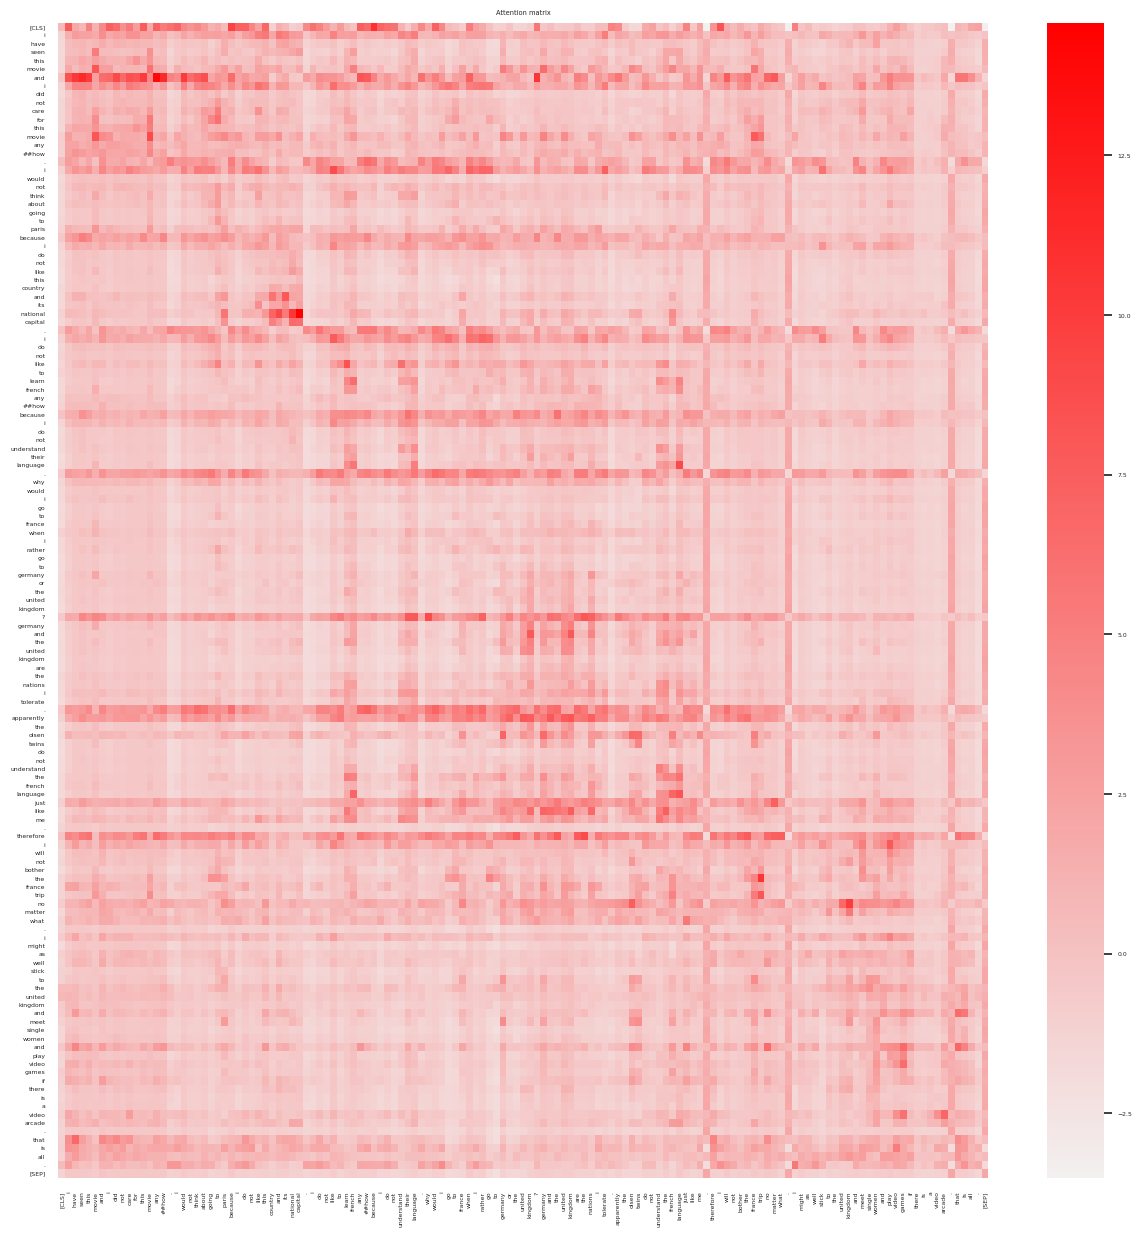

In [22]:
from matplotlib import pyplot
pyplot.figure(figsize=(15, 15))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.4)
sns.heatmap(a3, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');

pyplot.savefig("correct_pred_matrix", dpi=900)

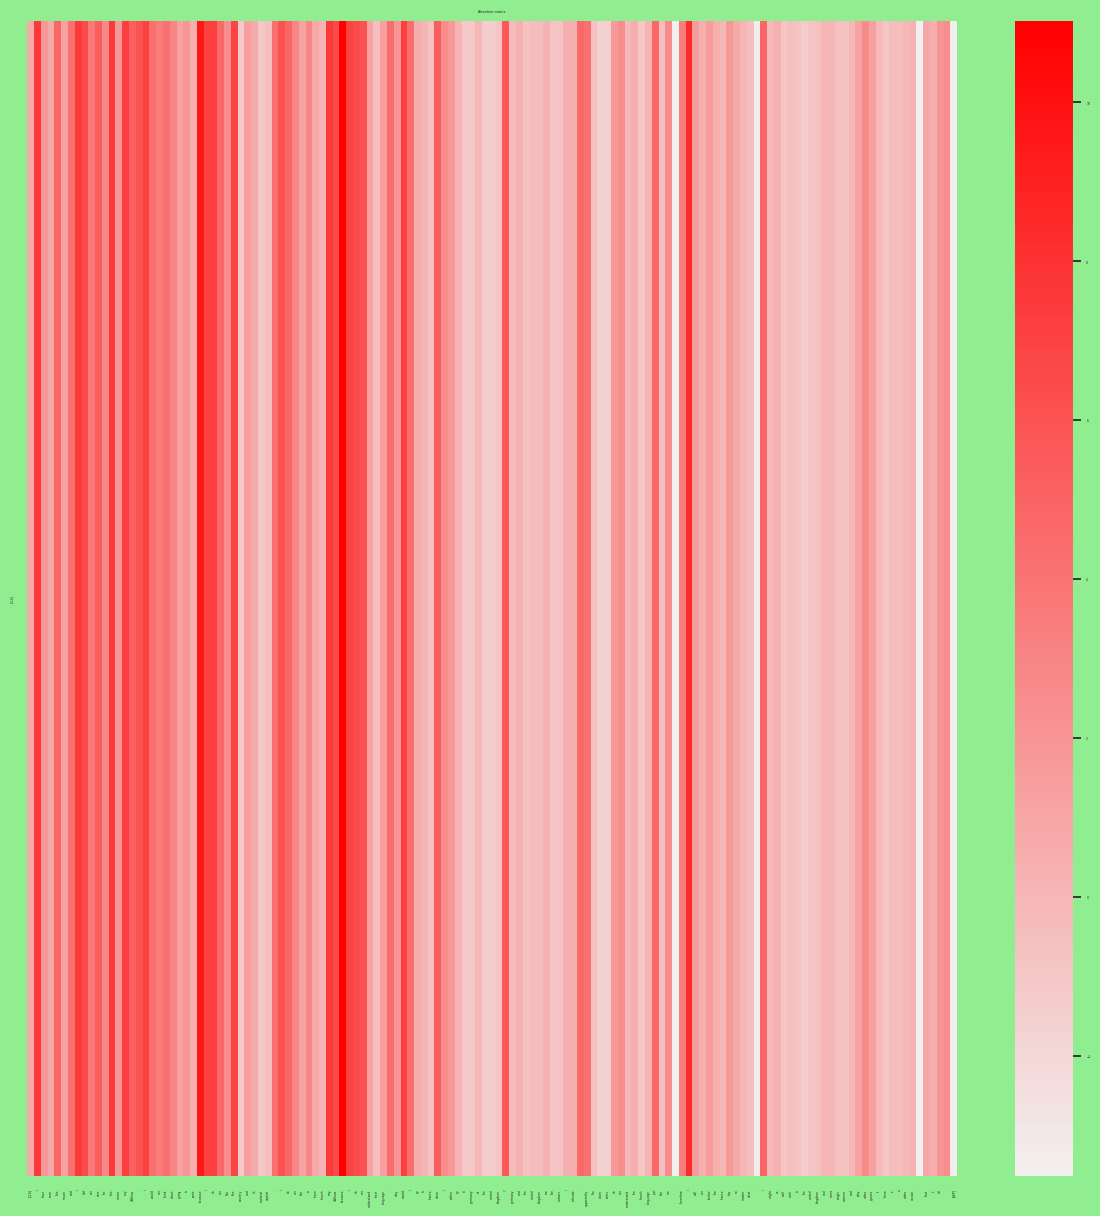

In [23]:
pyplot.figure(figsize=(15, 15))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.2)

sns.heatmap(a3.iloc[0:1,:], cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("correct_pred_full_cls", dpi=900)

In [24]:
a3_1 = a3.iloc[0:1,:50] #146
a3_2 = a3.iloc[0:1,50:100]
a3_3 = a3.iloc[0:1,100:(np.count_nonzero(test_tokens_ids[correct_prediction_ids[0]]))]

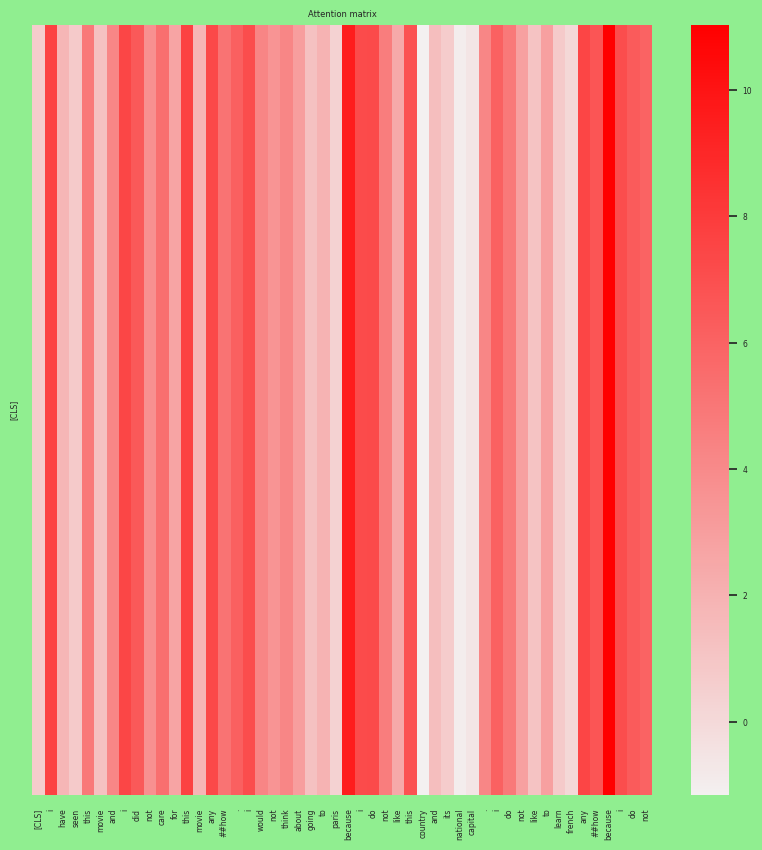

In [25]:
pyplot.figure(figsize=(10, 10))
pyplot.tight_layout()
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.5)
sns.heatmap(a3_1, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("part1_cls", dpi=400)

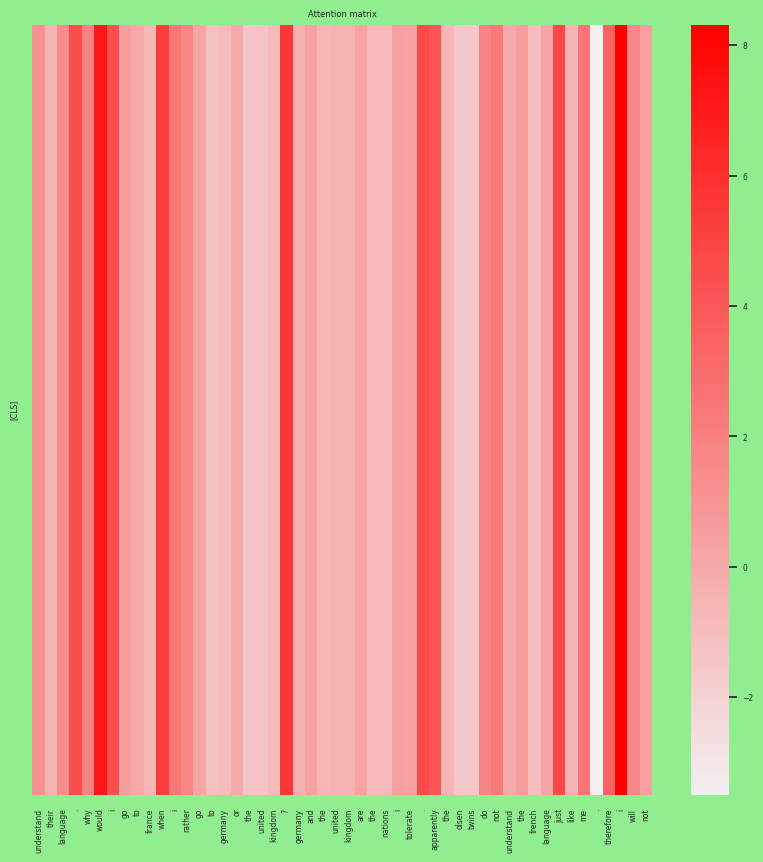

In [26]:
pyplot.figure(figsize=(10, 10))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.5)

sns.heatmap(a3_2, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("part2_cls", dpi=400)

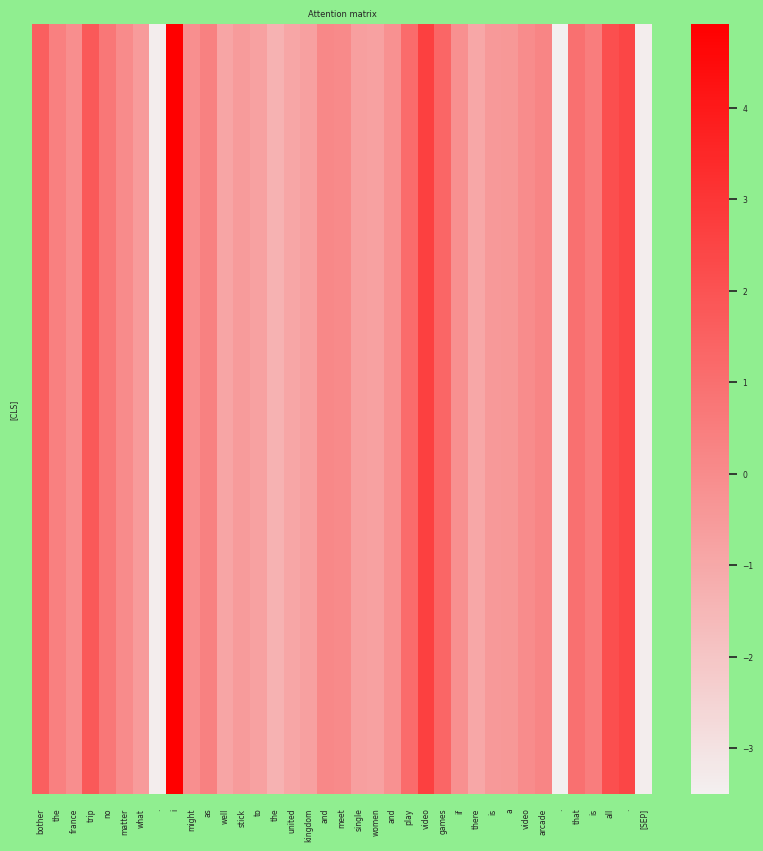

In [27]:
pyplot.figure(figsize=(10, 10))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.5)

sns.heatmap(a3_3, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("part3_cls", dpi=400)

In [28]:
_, _, attentions_incorrect = bert_clf.bert(torch.tensor(test_tokens_ids[incorrect_predictions_ids[0]:incorrect_predictions_ids[0]+1]).to(device), output_hidden_states=False, output_attentions=True)

In [29]:
print(tokenizer.decode(test_tokens_ids[incorrect_predictions_ids[0]]))
print((np.count_nonzero(test_tokens_ids[incorrect_predictions_ids[0]])))
word_ls2 = list(map(lambda x: reverse_word_index.get(int(x)), test_tokens_ids[incorrect_predictions_ids[0]]))

a4 = pd.DataFrame(attentions_incorrect[11][0][0].cpu().detach().numpy(), word_ls2, word_ls2)#layer x batch x head x seq_len x seq_len
a4 = (a4 - a4.mean())/a4.std()
a4 = a4.iloc[:np.count_nonzero(test_tokens_ids[incorrect_predictions_ids[0]]),:np.count_nonzero(test_tokens_ids[incorrect_predictions_ids[0]])]

[CLS] alan rickman & emma thompson give good performances with southern / new orleans accents in this detective flick. it's worth seeing for their scenes - and rickman's scene with hal holbrook. these three actors mannage to entertain us no matter what the movie, it seems. the plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. the fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things. the movie is worth a view - if for nothing more than entertaining performances by rickman, thompson, and holbrook. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

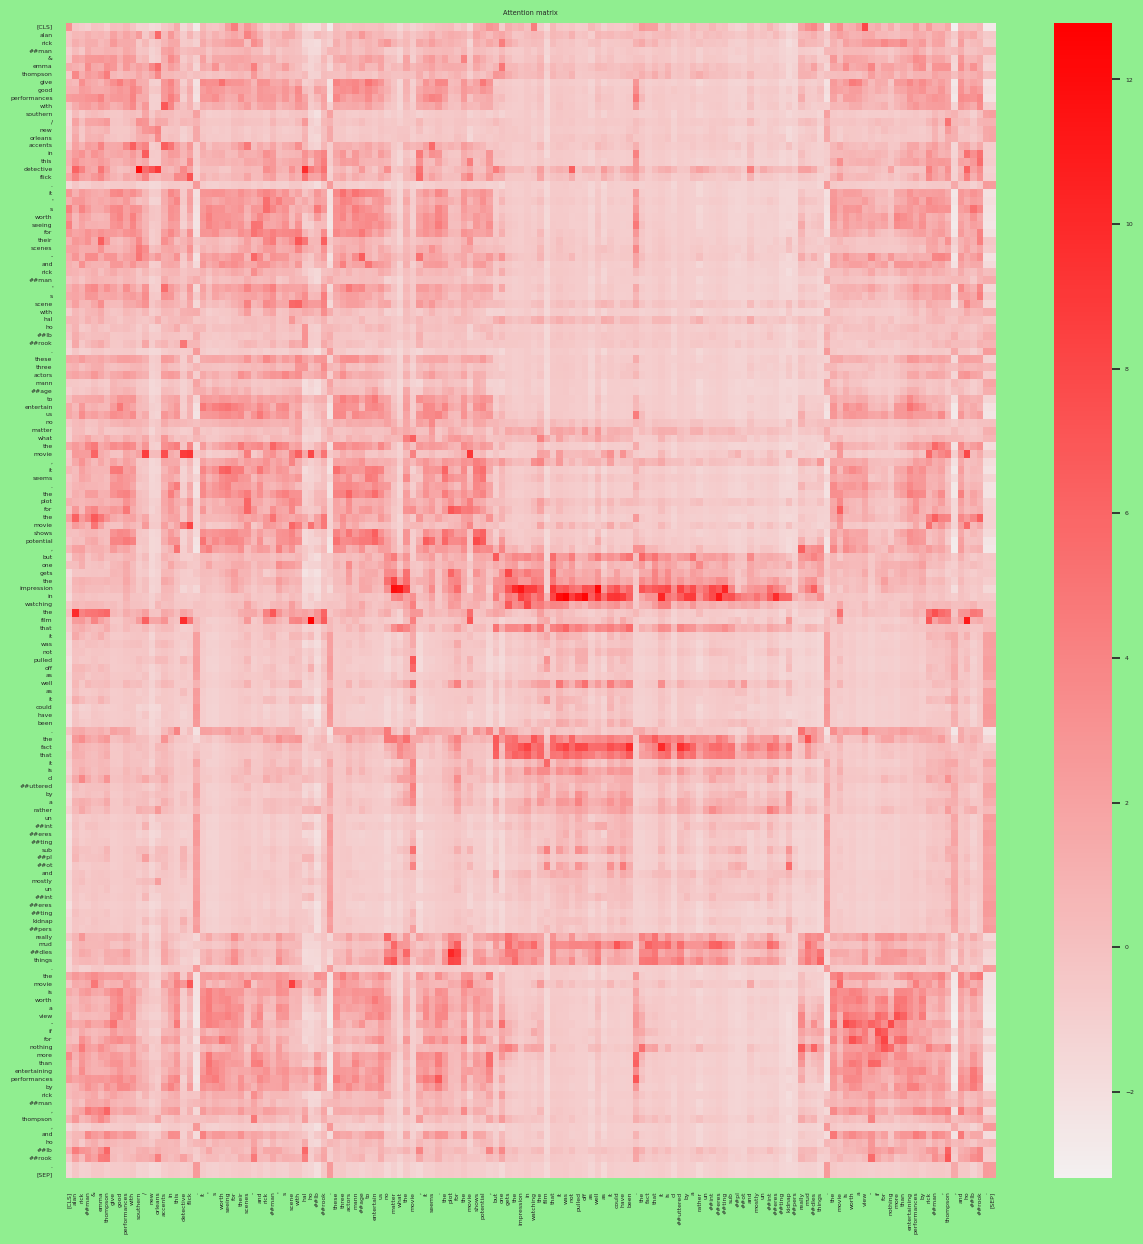

In [30]:
pyplot.figure(figsize=(15, 15))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.4)
sns.heatmap(a4, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');

pyplot.savefig("incorrect_pred_matrix", dpi=900)

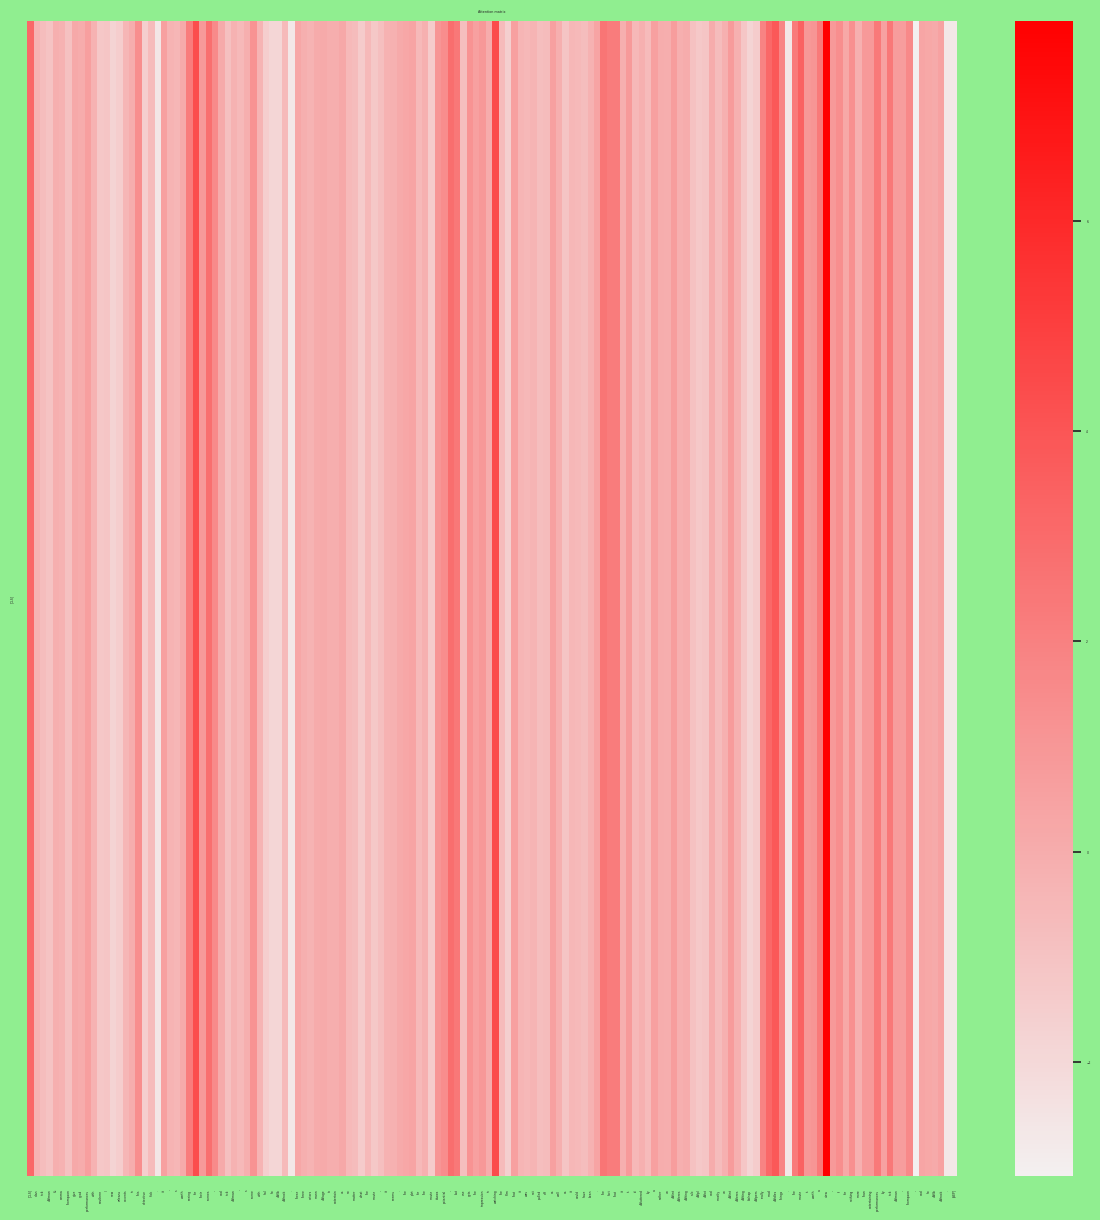

In [31]:
pyplot.figure(figsize=(15, 15))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.2)

sns.heatmap(a4.iloc[0:1,:], cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("incorrect_pred_full_cls", dpi=900)

In [32]:
a4_1 = a4.iloc[0:1,:50] #146
a4_2 = a4.iloc[0:1,50:100]
a4_3 = a4.iloc[0:1,100:(np.count_nonzero(test_tokens_ids[incorrect_predictions_ids[0]]))]

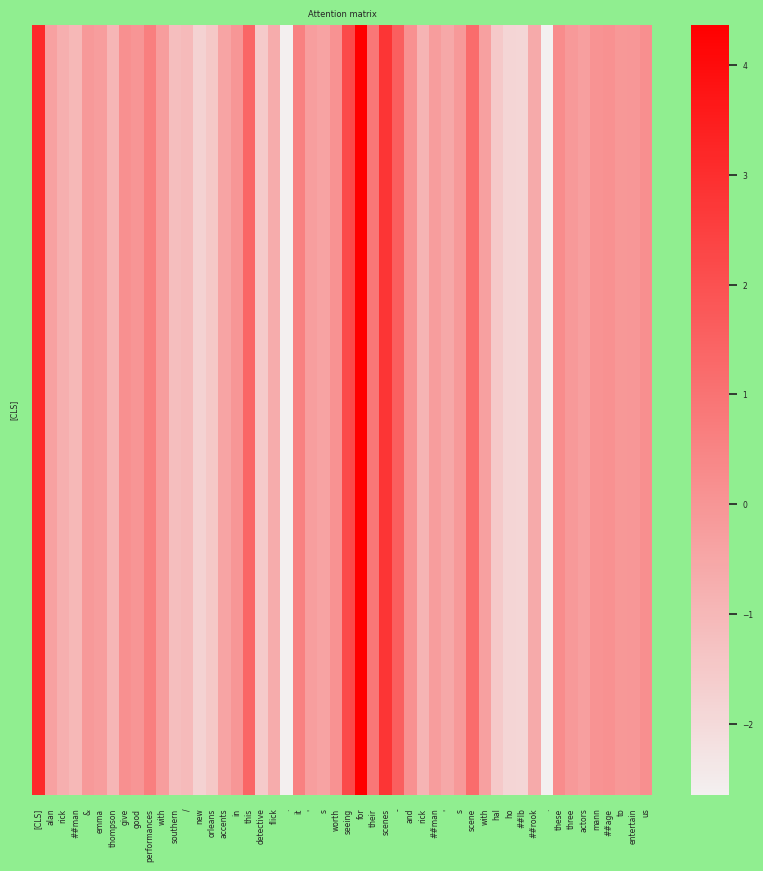

In [33]:
pyplot.figure(figsize=(10, 10))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.5)

sns.heatmap(a4_1, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("part1_cls_i", dpi=400)

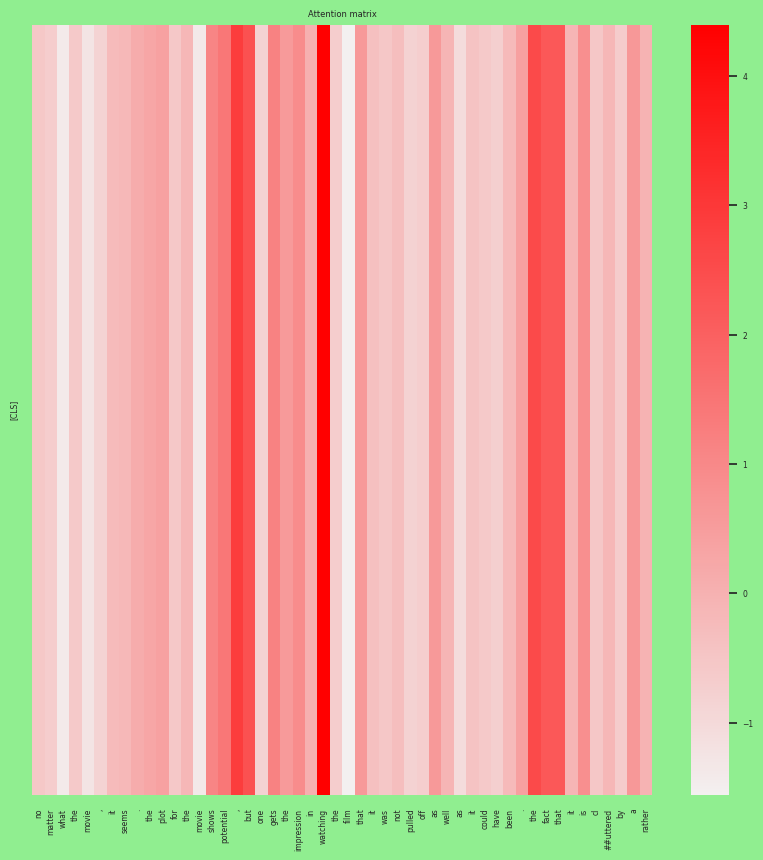

In [34]:
pyplot.figure(figsize=(10, 10))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.5)

sns.heatmap(a4_2, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("part2_cls_i", dpi=400)

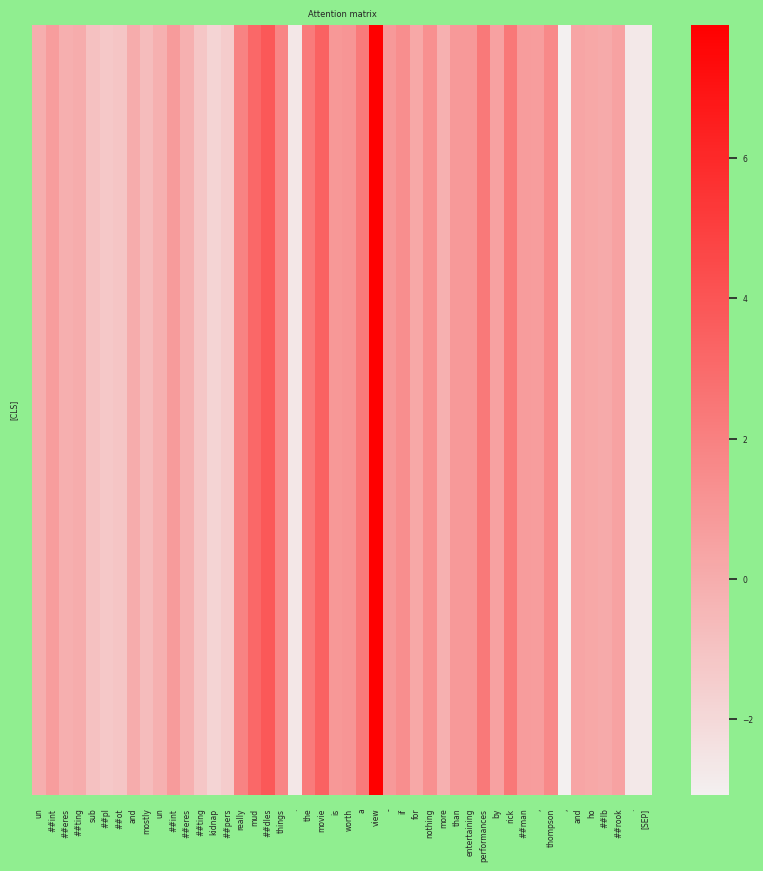

In [35]:
pyplot.figure(figsize=(10, 10))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'}, font_scale=0.5)

sns.heatmap(a4_3, cmap=sns.light_palette('red', as_cmap=True), linewidths=0, annot_kws={'size': 15}).set_title('Attention matrix');
pyplot.savefig("part3_cls_i", dpi=400)

In [45]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

47174